### Fonctions utilitaires

Compléter en ajoutant les fonctions de padding et de découpage en bloc.

In [9]:
import PIL
from PIL import Image
import numpy as np
import scipy as sp
import os
from math import log10, sqrt

def load(filename):
    toLoad= Image.open(filename)
    return np.array(toLoad)

def psnr(original, compressed):
    mse = np.mean((original.astype(int) - compressed) ** 2)
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr


### Utilitaires pour le calcul des palettes et des patchs

Fonctions auxiliaires pour manipuler les palettes, les pixels et les blocs. 

In [10]:
def check_padding(matrice: np.array)->bool:
    """Vérifie si la matrice est divisible par 4."""
    return matrice.shape[0] % 4 == 0 and matrice.shape[1] % 4 == 0

def padding(matrice: np.array)->np.array:
    """Ajoute des pixels noirs pour que l'image soit un multiple de 4."""
    if check_padding(matrice):
        return matrice
    else:
        rows_to_add = (4 - matrice.shape[0] % 4) % 4
        cols_to_add = (4 - matrice.shape[1] % 4) % 4
        padded_matrice = np.pad(matrice, ((0, rows_to_add), (0, cols_to_add), (0, 0)), mode='constant', constant_values=0)
        return padded_matrice

def decoupe_matrice(matrice: np.array)->list:
    """Découpe la matrice paddée en 4 blocs."""
    padded_matrice = padding(matrice)
    matrice4bloc = []
    rows_par_bloc = padded_matrice.shape[0] // 2
    cols_par_bloc = padded_matrice.shape[1] // 2

    for i in range(0, 2):
        for j in range(0, 2):
            bloc = padded_matrice[i * rows_par_bloc:(i + 1) * rows_par_bloc, j * cols_par_bloc:(j + 1) * cols_par_bloc]
            matrice4bloc.append(bloc)
    return matrice4bloc

def reconstruire_img(blocs:list, shape_original:np.array)->list:
    """Reconstruit l'image"""
    num_rows_per_bloc = shape_original[0] // 2
    num_cols_per_bloc = shape_original[1] // 2
    reconstructed = np.zeros((shape_original[0], shape_original[1], 3), dtype=blocs[0].dtype)  # S'assurer de la dimension des couleurs
    
    index = 0
    for i in range(2):
        for j in range(2):
            start_row = i * num_rows_per_bloc
            start_col = j * num_cols_per_bloc
            end_row = start_row + num_rows_per_bloc
            end_col = start_col + num_cols_per_bloc

            if end_row > shape_original[0]:
                end_row = shape_original[0]
            if end_col > shape_original[1]:
                end_col = shape_original[1]

            reconstructed[start_row:end_row, start_col:end_col, :] = blocs[index][:(end_row-start_row), :(end_col-start_col), :]
            index += 1

    return reconstructed

def tronque(n:int, p:int)->int:
    """Enlève les p derniers bits de l'entier n."""
    return (n >> p) << p

def create_palette(a, b)->np.array:
    """Créer une palette"""
    a_truncated = [tronque(a[0], 3), tronque(a[1], 2), tronque(a[2], 3)]
    b_truncated = [tronque(b[0], 3), tronque(b[1], 2), tronque(b[2], 3)]
    color2 = np.round((2 * np.array(a_truncated) / 3) + (np.array(b_truncated) / 3)).astype(int)
    color3 = np.round((np.array(a_truncated) / 3) + (2 * np.array(b_truncated) / 3)).astype(int)
    return np.array([a_truncated, color2, color3, b_truncated])


    check_padding(matrice: np.array) -> bool:

Vérifie si la taille de la matrice est divisible par 4. Retourne True si c'est le cas, False sinon.
padding(matrice: np.array) -> np.array:
Ajoute des pixels noirs à la matrice pour la rendre divisible par 4. Si la matrice est déjà un multiple de 4, elle la retourne telle quelle.

    decoupe_matrice(matrice: np.array) -> list:

Divise la matrice rembourrée en 4 blocs égaux et retourne une liste contenant ces blocs.

    reconstruire_img(blocs: list, shape_original: np.array) -> list:

Reconstruit l'image à partir des blocs. Il utilise les informations de taille d'origine pour couper les blocs si nécessaire et les placer correctement dans l'image finale.

    tronque(n: int, p: int) -> int:

Enlève les p derniers bits de l'entier n. Cela fonctionne en décalant les bits de p positions vers la droite, puis en les ramenant vers la gauche, supprimant ainsi les bits de poids faible.

    create_palette(a, b) -> np.array:

Crée une palette de couleurs à partir de deux couleurs a et b. Cette fonction est conçue pour un format d'image spécifique où chaque couleur est représentée par 3 composantes RVB, et les composantes sont tronquées en fonction de certaines règles. La palette résultante contient quatre couleurs, deux basées sur a et b, chacune tronquée de différentes manières pour produire une interpolation de couleur.







### Les méthodes de choix des couleurs de la palette


On peut essayer plusieurs stratégies pour calculer les deux couleurs a et b:
* Calculer la couleur minimale et maximale
* Prendre des couleurs moyennes (calculer moyenne et variance pour trouver les meilleurs valeurs) 
* Calculer 10 valeurs au hasard et prendre la meilleure
* Partir d'un choix et perturber pour améliorer le résultat: on teste la meilleure modification de 16 d'un des canaux d'une des couleurs

In [11]:
def select_colors(block:list, num_colors:int=5)->np.array:
    pixels = block.reshape(-1, 3)
    color_range = np.ptp(pixels, axis=0)
    segment_size = color_range / num_colors
    segment_centers = [np.mean(pixels, axis=0) - (color_range / 2) + (i * segment_size) for i in range(num_colors)]
    return np.array(segment_centers)

def select_min_max_colors(block:list)->tuple:
    selected_colors = select_colors(block, num_colors=2)
    return tuple(selected_colors)

def select_random_best_colors(block:list)->tuple:
    pixels = block.reshape(-1, 3)
    best_distance = 0
    best_pair = (pixels[0], pixels[1])
    for _ in range(10):
        idx_a, idx_b = np.random.choice(len(pixels), 2, replace=False)
        distance = np.linalg.norm(pixels[idx_a] - pixels[idx_b])
        if distance > best_distance:
            best_distance = distance
            best_pair = (pixels[idx_a], pixels[idx_b])
    return best_pair

def select_mean_std_colors(block:list)->tuple:
    pixels = block.reshape(-1, 3)
    mean_color = np.mean(pixels, axis=0)
    std_dev = np.std(pixels, axis=0)
    color_a = np.clip(mean_color - std_dev, 0, 255).astype(int)
    color_b = np.clip(mean_color + std_dev, 0, 255).astype(int)
    return color_a, color_b

    select_colors(block: list, num_colors: int = 5) -> np.array :

Cette fonction sélectionne un certain nombre de couleurs à partir d'un bloc donné. Elle réduit d'abord le bloc en une liste de pixels, puis détermine la plage de couleurs dans le bloc. Ensuite, elle divise cette plage en segments et sélectionne les centres de ces segments comme les couleurs finales.

    select_min_max_colors(block: list) -> tuple :

Cette fonction utilise select_colors pour choisir deux couleurs qui représentent la couleur minimale et maximale dans le bloc.

    select_random_best_colors(block: list) -> tuple :

Cette fonction choisit aléatoirement deux pixels dans le bloc et les considère comme les meilleures couleurs si leur distance euclidienne est maximisée. Elle répète cette sélection plusieurs fois (10 fois dans ce cas) pour trouver les meilleures couleurs.

    select_mean_std_colors(block: list) -> tuple :

Cette fonction calcule la couleur moyenne et l'écart-type des pixels dans le bloc. Ensuite, elle crée deux couleurs en ajustant la couleur moyenne par l'écart-type, l'une en soustrayant l'écart-type et l'autre en l'ajoutant, et en les limitant à l'intervalle [0, 255] pour chaque composante RVB.

### Encodage d'un bloc

Écrire ici le code qui permet d'encoder un bloc et une palette en un entier.

In [12]:
def find_closest_palette_color(palette, pixel):
    """Trouve l'indice de la couleur dans la palette la plus proche du pixel donné."""
    distances = np.linalg.norm(palette - pixel, axis=1)
    return np.argmin(distances)

def encode_color(color):
    """Encode color 5:6:5 bit RGB"""
    r = (color[0] >> 3) & 0x1F
    g = (color[1] >> 2) & 0x3F
    b = (color[2] >> 3) & 0x1F
    return (r << 11) | (g << 5) | b

def encode_patch(a, b, indices:list)->int:
    """Code un patch en utilisant les valeurs a et b des couleurs et les indices dans la palette"""
    a_norm=encode_color(a)
    b_norm=encode_color(b)
    indices_binary = ''.join(format(index, '02b') for index in indices)
    patch_binary = indices_binary + format(b_norm, '016b') + format(a_norm, '016b')
    patch_int = int(patch_binary, 2)
    return patch_int


    find_closest_palette_color(palette, pixel) :

Cette fonction trouve l'indice de la couleur dans la palette qui est la plus proche du pixel donné. Elle calcule d'abord les distances euclidiennes entre le pixel et chaque couleur de la palette, puis retourne l'indice de la couleur ayant la distance minimale.

    encode_color(color) :

Cette fonction encode une couleur RVB (rouge, vert, bleu) sur 5:6:5 bits. Elle prend les composantes de couleur (r, g, b), les décale pour correspondre à la plage de bits spécifiée (5 bits pour le rouge et le bleu, 6 bits pour le vert) et les assemble dans un entier en utilisant des opérations de décalage de bits.

    encode_patch(a, b, indices: list) :

Cette fonction code un patch en utilisant les valeurs a et b des couleurs (encodées par encode_color) et les indices des couleurs dans la palette. Elle construit une chaîne binaire où les indices sont représentés sur 2 bits chacun, suivis des valeurs encodées de la couleur b puis de la couleur a. Cette chaîne binaire est ensuite convertie en un entier.

### Écriture et lecture dans un fichier

In [13]:
def write_image_info(file_path:str, height:int, width:int)->None:
    """Signe le fichier"""
    with open(file_path, "w") as f:
        f.write("BC1\n")
        f.write(f"{height} {width}\n")

def write_patches(file_path, patch_codes)->None:
    """Ajoute les patch a chaque ligne"""
    with open(file_path, "a") as f:
        for codes in patch_codes:
            f.write(f"{codes}\n")

    write_image_info(file_path: str, height: int, width: int) -> None :

Cette fonction écrit les informations de base de l'image dans un fichier. Elle ouvre le fichier spécifié en mode écriture ("w"), puis écrit le type de compression (BC1) suivi des dimensions de l'image (hauteur et largeur).

    write_patches(file_path, patch_codes) -> None :

Cette fonction ajoute les codes de patch à un fichier, un par ligne. Elle ouvre le fichier en mode ajout ("a"), puis écrit chaque code de patch dans une nouvelle ligne du fichier.

### Fonctions de test

Écrire ici tous vos tests. Chaque fonction écrite doit être testée.

In [8]:
def test_check_padding()->None:
    """Vérifie la fonction check_padding()"""
    matrices = [
        (np.zeros((4, 4)), True),
        (np.zeros((8, 8)), True),
        (np.zeros((5, 5)), False),
        (np.zeros((4, 5)), False)
    ]

    # Tester les matrices
    for index, (matrix, expected) in enumerate(matrices):
        try:
            assert check_padding(matrix) == expected, f"Test {index + 1} échoué."
            print(f"Test {index + 1} réussi.")
        except AssertionError as e:
            print(e)

def test_padding()->None:
    """Vérifie la fonction padding()"""
    # Créer des matrices de test
    matrices = [
        np.random.randint(0, 256, (10, 10, 3)),  # Matrice déjà multiple de 4
        np.random.randint(0, 256, (11, 11, 3)),  # Matrice non-multiple de 4
        np.random.randint(0, 256, (15, 17, 3)),  # Autre matrice non-multiple de 4
    ]

    # Tester chaque matrice
    for mat in matrices:
        padded_mat = padding(mat)
        rows, cols = padded_mat.shape[:2]
        
        # Vérifier si les dimensions sont multiples de 4
        assert rows % 4 == 0, f"Le nombre de lignes {rows} n'est pas un multiple de 4"
        assert cols % 4 == 0, f"Le nombre de colonnes {cols} n'est pas un multiple de 4"
        
        # Vérifier si les valeurs ajoutées sont des zéros
        if rows > mat.shape[0]:
            assert np.all(padded_mat[mat.shape[0]:, :, :] == 0), "Les pixels ajoutés en ligne ne sont pas tous à zéro"
        if cols > mat.shape[1]:
            assert np.all(padded_mat[:, mat.shape[1]:, :] == 0), "Les pixels ajoutés en colonne ne sont pas tous à zéro"

        print(f"Test réussi pour la matrice de taille initiale {mat.shape[:2]}")

def test_decoupe_matrice()->None:
    """Vérifie que la longueur matrice4bloc est de 4"""
    matrice = np.random.randint(0, 256, (10, 10, 3))
    blocs = decoupe_matrice(matrice)
    
    # Vérification du nombre de blocs
    assert len(blocs) == 4, "Il y a exactement 4 blocs"
    print("Test Réussi")


def test_tronque():
    """Vérifie la fonction tronque"""
    assert tronque(218, 3) == 0b11011000, "Erreur : Troncature incorrecte"
    assert tronque(170, 2) == 0b10101000, "Erreur : Troncature incorrecte"
    assert tronque(255, 4) == 0b11110000, "Erreur : Troncature incorrecte"

def test_create_palette():
    a = [255, 128, 0]  # Exemple de couleur a
    b = [0, 128, 255]  # Exemple de couleur b
    
    expected_result = np.array([[224, 85, 0], [170, 85, 64], [85, 85, 128], [0, 85, 192]])
    assert np.array_equal(create_palette(a, b), expected_result), "Erreur : La palette créée est incorrecte."

def test_select_colors():
    # Création d'un bloc de pixels
    block = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 255]])

    # Test avec num_colors = 2
    expected_result = np.array([[127.5, 127.5, 127.5], [382.5, 382.5, 382.5]])
    assert np.allclose(select_colors(block, num_colors=2), expected_result), "Erreur : Sélection incorrecte des couleurs."

def test_select_min_max_colors():
    # Création d'un bloc de pixels
    block = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 255]])

    # Test de la sélection des couleurs minimale et maximale
    expected_result = ([0.0, 0.0, 0.0], [255.0, 255.0, 255.0])
    assert select_min_max_colors(block) == expected_result, "Erreur : Sélection incorrecte des couleurs min/max."

def test_select_random_best_colors():
    # Création d'un bloc de pixels
    block = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 255]])

    # Test de la sélection aléatoire des meilleures couleurs
    selected_colors = select_random_best_colors(block)
    assert selected_colors in [(np.array([255, 0, 0]), np.array([255, 255, 255])),
                               (np.array([0, 0, 255]), np.array([255, 0, 0])),
                               (np.array([0, 255, 0]), np.array([0, 0, 255]))], "Erreur : Sélection incorrecte des couleurs aléatoires."

def test_select_mean_std_colors():
    # Création d'un bloc de pixels
    block = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 255]])

    # Test de la sélection des couleurs basée sur la moyenne et l'écart type
    expected_result = (np.array([63, 63, 63]), np.array([191, 191, 191]))
    assert select_mean_std_colors(block) == expected_result, "Erreur : Sélection incorrecte des couleurs basée sur la moyenne et l'écart type."

def test_encode_patch():
    a = [255, 0, 0]  # Exemple de couleur a
    b = [0, 255, 0]  # Exemple de couleur b
    indices = [0, 1, 2, 3]  # Exemple d'indices dans la palette

    # Tester l'encodage d'un patch avec les couleurs et les indices donnés
    expected_result = 0b00011010000000000000000011111111
    assert encode_patch(a, b, indices) == expected_result, "Erreur : Encodage incorrect du patch."

    

    ***Compression***

In [14]:

def compress_image(input_filepath: str, output_file_path: str) -> None:
    """Compresse l'image"""
    image = load(input_filepath)
    padded_image = padding(image)
    block_size = 4
    patch_codes = []

    for i in range(0, padded_image.shape[0], block_size):
        for j in range(0, padded_image.shape[1], block_size):
            block = padded_image[i:i+block_size, j:j+block_size]
            initial_colors = select_min_max_colors(block)

            a = initial_colors[0]
            b = initial_colors[1]

            a = a.astype(np.uint16)
            b = b.astype(np.uint16)
            
            palette = create_palette(a, b)
            indices = [find_closest_palette_color(palette, pixel) for pixel in block.reshape(-1, 3)]
            indices = np.clip(indices, 0, 3)
            
            encoded_patch = encode_patch(a, b, indices)
            patch_codes.append(encoded_patch)

    write_image_info(output_file_path, padded_image.shape[0], padded_image.shape[1])
    write_patches(output_file_path, patch_codes)

#compress_image("proc.jpg", "compression_proc.bc1")

Cette fonction `compress_image` prend en entrée le chemin d'accès du fichier d'entrée (l'image à compresser) et le chemin d'accès du fichier de sortie (où la version compressée sera enregistrée). 

Voici ce qu'elle fait :

1. Charger l'image à partir du fichier d'entrée.
2. Rembourrer l'image si nécessaire pour que sa taille soit un multiple de 4.
3. Définir la taille du bloc à 4 (4x4 pixels).
4. Parcourir l'image par blocs de taille 4x4.
5. Pour chaque bloc, sélectionner les couleurs initiales en utilisant la fonction `select_min_max_colors`.
6. Créer une palette de couleurs à partir des couleurs initiales.
7. Trouver les indices des couleurs de la palette les plus proches pour chaque pixel du bloc.
8. Encoder le patch à l'aide des couleurs initiales et des indices de couleur.
9. Écrire les informations de base de l'image (type de compression, dimensions) dans le fichier de sortie.
10. Écrire les codes de patch dans le fichier de sortie, un par ligne.

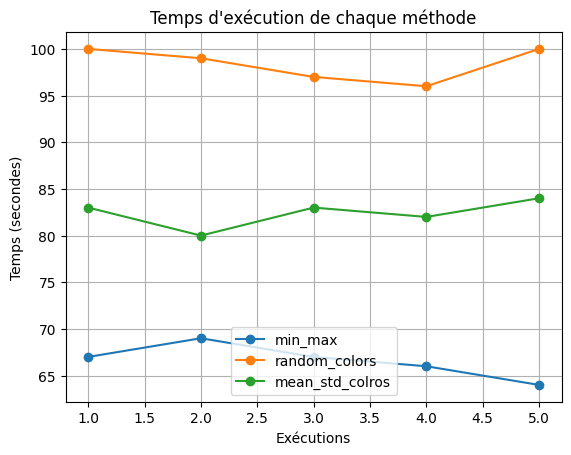

In [22]:
import matplotlib.pyplot as plt

#Nos récoltes de temps en secondes avec chaque fonctions
min_max_temps = [67, 69, 67, 66, 64]
random_colors_temps = [100, 99, 97, 96, 100]
mean_std_colros_temps = [83, 80, 83, 82, 84]

x = np.arange(1, len(min_max_temps) + 1)

plt.plot(x, min_max_temps, marker='o', label='min_max')
plt.plot(x, random_colors_temps, marker='o', label='random_colors')
plt.plot(x, mean_std_colros_temps, marker='o', label='mean_std_colros')

plt.xlabel('Exécutions')
plt.ylabel('Temps (secondes)')
plt.title('Temps d\'exécution de chaque méthode')
plt.legend()


plt.grid(True)
plt.show()

Nous observons que min_max à le temps d'execution le plus faible c'est pourquoi il est plus judicieux d'intégrer cette méthode dans la fonction de compression.

    ***Décompression***

In [15]:
def decode_color(code):
    """Décode une couleur 5:6:5 bit RGB en ajustant pour les 8 bits par canal"""
    r = (code >> 11) & 0x1F
    g = (code >> 5) & 0x3F
    b = code & 0x1F
    return np.array([(r * 255 // 31), (g * 255 // 63), (b * 255 // 31)])

def decode_patch(code):
    """Décrypte les informations du patch"""
    indices_encoded = code & 0xFFFFFFFF
    b_encoded = (code >> 32) & 0xFFFF
    a_encoded = (code >> 48) & 0xFFFF
    a = decode_color(a_encoded)
    b = decode_color(b_encoded)
    indices = [(indices_encoded >> (2 * i)) & 0x3 for i in range(16)]
    return a, b, indices

def read_image_info(file_path:str)->None:
    """Lit les informations de l'image depuis le fichier compressé, en ignorant la première ligne."""
    with open(file_path, "r") as f:
        f.readline()
        dimensions = f.readline().strip().split()
        height, width = int(dimensions[0]), int(dimensions[1])
        patch_codes = [line.strip() for line in f]
    return height, width, patch_codes

def decompress_image(file_path:str, output_image_path:str)->None:
    """Décompresse les patch en une image"""
    height, width, patch_codes = read_image_info(file_path)
    image = np.zeros((height, width, 3), dtype=np.uint8)
    block_size = 4
    blocks_per_row = width // block_size

    for patch_index, patch_code in enumerate(patch_codes):
        row = (patch_index // blocks_per_row) * block_size
        col = (patch_index % blocks_per_row) * block_size
        a, b, indices = decode_patch(int(patch_code))
        palette = create_palette(a, b)

        for i in range(block_size):
            for j in range(block_size):
                idx = indices[i * block_size + j]
                image[row + i, col + j] = palette[idx]

    Image.fromarray(image).save(output_image_path)

#decompress_image("compression_fin.bc1", "decompress_fin.jpg")

    decode_color(code) :

Cette fonction décode une couleur RVB codée sur 5:6:5 bits en ajustant pour les 8 bits par canal. Elle extrait les composantes de couleur à partir du code entier et les ajuste à la plage complète de 0 à 255.

    decode_patch(code) :

Cette fonction décrypte les informations d'un patch. Elle extrait les codes de couleur encodés pour les couleurs a et b, ainsi que les indices de couleur pour chaque pixel du patch.

    read_image_info(file_path: str) :

Cette fonction lit les informations de base de l'image depuis le fichier compressé, en ignorant la première ligne qui contient le type de compression. Elle récupère les dimensions de l'image et les codes de patch à partir des lignes suivantes du fichier.

    decompress_image(file_path: str, output_image_path: str) :

Cette fonction décompresse les patches pour reconstituer l'image. Elle utilise les informations lues depuis le fichier compressé pour décoder chaque patch, puis les place correctement dans l'image résultante. Enfin, elle enregistre l'image décompressée dans un fichier spécifié.

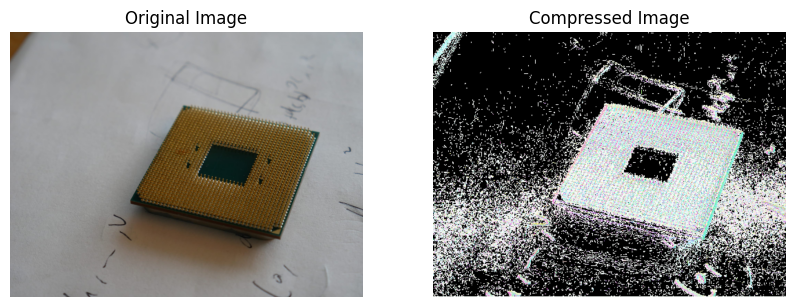

In [30]:
def plot_images(original_image, compressed_image):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    axes[1].imshow(compressed_image)
    axes[1].set_title('Compressed Image')
    axes[1].axis('off')
    plt.show()

original_image = load("proc.jpg")
compressed_image = load("decompress_proc.jpg")
plot_images(original_image, compressed_image)

Nous pouvons observer à gauche l'image original, à droite l'image compressée, delà nous pouvons observer à droite qu'il y a beaucoup de bruit sur l'image, et beaucoup de pixels noir. Nous pouvons formuler l'hypothèse que l'image à subit des pertes conséquentes d'information lors de la compression.

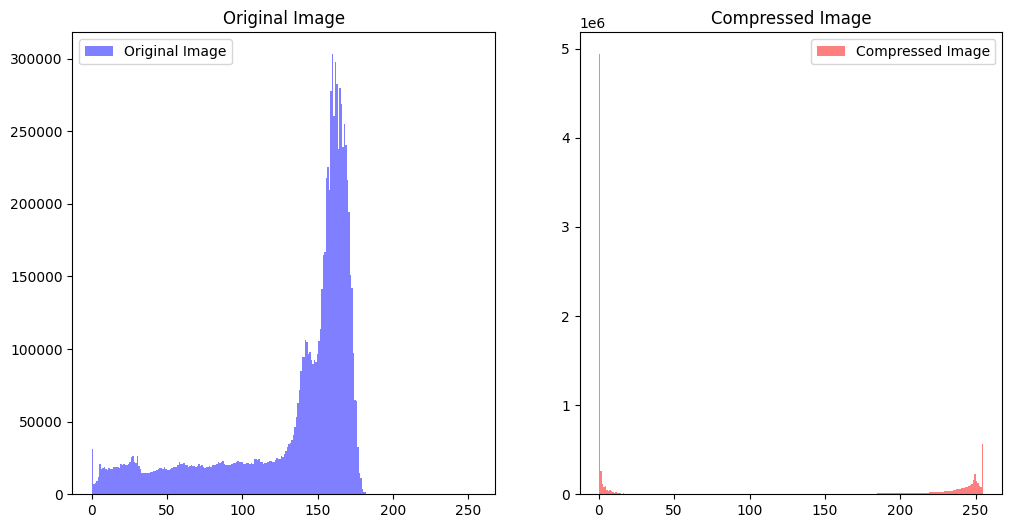

In [32]:
def plot_color_histograms(original_image, compressed_image):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].hist(original_image.ravel(), bins=256, color='blue', alpha=0.5, label='Original Image')
    axes[0].legend()
    axes[0].set_title('Original Image')
    axes[1].hist(compressed_image.ravel(), bins=256, color='red', alpha=0.5, label='Compressed Image')
    axes[1].legend()
    axes[1].set_title('Compressed Image')
    plt.show()

original_image = load("proc.jpg")
compressed_image = load("decompress_proc.jpg")

plot_color_histograms(original_image, compressed_image)

En observant cette Histogramme de couleurs de ces deux images, nous voyons à gauche (l'image original) qu'il y a une moyenne de pixels constante entre 0 et 150 en dessous des 50.000, à partir de 150 nous observons deux pique un premier à 100.000 un second à 300.000. A droite nous voyons un pique fondamental à 0 pixel et un vide entre 20 et 170, pour obtenir un léger pique à 250. Or, nous savons que :

1.Axe des x : L'axe horizontal de l'histogramme représente les différentes valeurs possibles des couleurs. Pour une image en niveaux de gris, cela varie généralement de 0 à 255, où 0 représente le noir et 255 représente le blanc. Pour une image en couleur, chaque composante de couleur (rouge, vert, bleu) est représentée sur l'axe des x, allant également de 0 à 255.

2.Axe des y : L'axe vertical représente le nombre de pixels ayant la valeur de couleur correspondante sur l'axe des x. Plus la hauteur de la barre est élevée, plus il y a de pixels ayant cette valeur de couleur dans l'image.

3.Couleurs : Dans le cas d'un histogramme en niveaux de gris, toutes les barres de l'histogramme seront de la même couleur. Cependant, pour un histogramme de couleur, chaque composante de couleur (rouge, vert, bleu) peut avoir une couleur différente, généralement rouge pour la composante rouge, vert pour la composante verte et bleu pour la composante bleue.

4.En regardant l'histogramme, vous pouvez voir comment les valeurs de couleur sont réparties dans l'image. Par exemple, si l'histogramme des couleurs est déplacé vers la gauche, cela signifie qu'il y a plus de pixels foncés dans l'image. Si l'histogramme est déplacé vers la droite, cela signifie qu'il y a plus de pixels clairs. Si l'histogramme est uniformément réparti sur toute la plage de valeurs, cela signifie que l'image contient une grande variété de couleurs.

Nous pouvons conclure que l'image subit bien des pertes et sont illustré par le vide dans le graphique de droite.

    ***Interface***


In [19]:
import tkinter as tk
from tkinter import filedialog, messagebox

def select_compress_file():
    filepath = filedialog.askopenfilename()
    compress_entry.delete(0, tk.END)
    compress_entry.insert(0, filepath)

def select_decompress_file():
    filepath = filedialog.askopenfilename()
    decompress_entry.delete(0, tk.END)
    decompress_entry.insert(0, filepath)

def compress():
    input_filepath = compress_entry.get()
    if not os.path.isfile(input_filepath):
        messagebox.showerror("Erreur", "Fichier invalide.")
        return

    output_filepath = os.path.splitext(input_filepath)[0] + ".bc1"
    compress_image(input_filepath, output_filepath)
    messagebox.showinfo("Compression terminée", "L'image a été compressée avec succès.")

def decompress():
    input_filepath = decompress_entry.get()
    if not os.path.isfile(input_filepath) or not input_filepath.endswith('.bc1'):
        messagebox.showerror("Erreur", "Fichier invalide ou non pris en charge.")
        return

    output_filepath = os.path.splitext(input_filepath)[0] + "2.jpg"
    decompress_image(input_filepath, output_filepath)
    Image.open(output_filepath).show()


root = tk.Tk()
root.title("Compresseur/Décompresseur d'image")

compress_frame = tk.Frame(root)
compress_frame.pack(padx=10, pady=10)

compress_label = tk.Label(compress_frame, text="Compression: Sélectionnez l'image à compresser:")
compress_label.grid(row=0, column=0, sticky="w")

compress_entry = tk.Entry(compress_frame, width=50)
compress_entry.grid(row=0, column=1, padx=5, pady=5)

compress_browse_button = tk.Button(compress_frame, text="Parcourir", command=select_compress_file)
compress_browse_button.grid(row=0, column=2, padx=5, pady=5)

compress_button = tk.Button(compress_frame, text="Compresser", command=compress)
compress_button.grid(row=1, columnspan=3, padx=5, pady=5)

decompress_frame = tk.Frame(root)
decompress_frame.pack(padx=10, pady=10)

decompress_label = tk.Label(decompress_frame, text="Décompression: Sélectionnez le fichier .bc1 à décompresser:")
decompress_label.grid(row=0, column=0, sticky="w")

decompress_entry = tk.Entry(decompress_frame, width=50)
decompress_entry.grid(row=0, column=1, padx=5, pady=5)

decompress_browse_button = tk.Button(decompress_frame, text="Parcourir", command=select_decompress_file)
decompress_browse_button.grid(row=0, column=2, padx=5, pady=5)

decompress_button = tk.Button(decompress_frame, text="Décompresser et afficher", command=decompress)
decompress_button.grid(row=1, columnspan=3, padx=5, pady=5)

root.mainloop()